### Bitmap Mask Matching
This notebook explores matching two puzzle pieces in the bitmask domain. After finding a set of anchoring points, We switch back to bitmap domain to extract a mask and try to align the two pieces.

In [2]:
import cv2
from matplotlib import pyplot
import numpy as np
import os

import piece
import match
import math_utils

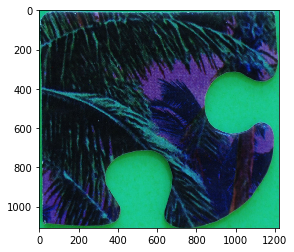

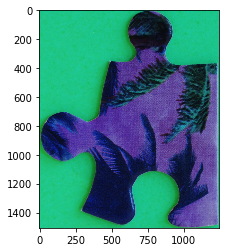

In [3]:
DATA_DIR = '../data/unicorn/'
p1 = piece.read_piece(os.path.join(DATA_DIR, '61.jpg'))
p2 = piece.read_piece(os.path.join(DATA_DIR, '44.jpg'))
pyplot.figure()
pyplot.imshow(p1.image)
pyplot.figure()
pyplot.imshow(p2.image)

Anchoring points are: (1160, 574) and (1167, 357)
Anchoring points are: (912, 363) and (645, 316)


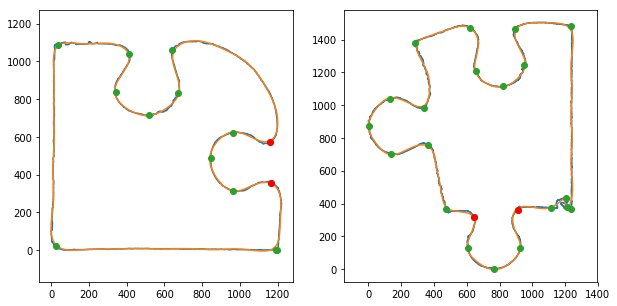

In [4]:
def get_anchor_points(c, cutoff=None, threshold=6e-3, plot=False):
    kwargs = {}
    if cutoff:
        kwargs['cutoff'] = cutoff
    cs = match._smooth_contour(c, cutoff=3.5e-3)
    k = math_utils.curvature(cs)
    cr = math_utils.zero_crossings(np.gradient(k))
    cr = cr[np.abs(k[cr]) > threshold]
    if plot:
        pyplot.plot(c[:, 0], c[:, 1])
        pyplot.plot(cs[:, 0], cs[:, 1])
        pyplot.plot(c[cr, 0], c[cr, 1], 'o')
    return cr

pyplot.figure(figsize=(10, 5))
selection = ((8, 12), (3, 7))
for i, contour, select in zip((1, 2), (p1.contour, p2.contour), selection):
    pyplot.subplot(1, 2, i)
    cr = get_anchor_points(contour, plot=True)
    cr = np.array([cr[select[0]], cr[select[1]]])
    print('Anchoring points are: ({x1}, {y1}) and ({x2}, {y2})'.format(x1=contour[cr[0], 0],
                                                                       y1=contour[cr[0], 1],
                                                                       x2=contour[cr[1], 0],
                                                                       y2=contour[cr[1], 1]))
    pyplot.plot(contour[cr, 0], contour[cr, 1], 'ro')
    pyplot.axis('equal')
pyplot.show()

[[ 763.70795426  215.62997142]
 [1313.42201715  715.37002858]]


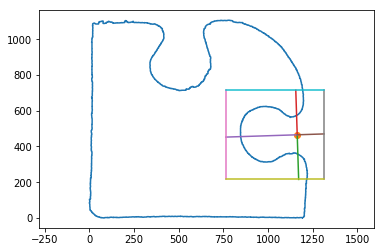

In [5]:
# Assume points are given in clockwise order along the contour.
a1 = np.array([[1160, 574], [1167, 357]])
a2 = np.array([[912, 363], [645, 316]])

a = a1
contour = p1.contour
cavity = False

margin_narrow = 250
margin_wide_long = 400
margin_wide_short = 150

delta = np.diff(a, axis=0)[0]
center = a[0] + delta / 2
narrow_dir = delta / np.linalg.norm(delta)
wide_dir = np.cross(narrow_dir, np.array([0, 0, 1]))[:2]
if cavity:
    wide_dir = -wide_dir


boundary_wide_long = center + wide_dir * margin_wide_long
boundary_wide_short = center - wide_dir * margin_wide_short
boundary_narrow1 = center + narrow_dir * margin_narrow
boundary_narrow2 = center - narrow_dir * margin_narrow

boundary = np.vstack([boundary_wide_short, boundary_wide_long, boundary_narrow1, boundary_narrow2])
bounds = np.vstack([np.min(boundary, axis=0), np.max(boundary, axis=0)])
print(bounds)

def plot_bounds(b):
    xlow = b[0, 0]
    xhigh = b[1, 0]
    ylow = b[0, 1]
    yhigh = b[1, 1]
    pyplot.plot((xlow, xlow), (ylow, yhigh))
    pyplot.plot((xhigh, xhigh), (ylow, yhigh))
    pyplot.plot((xlow, xhigh), (ylow, ylow))
    pyplot.plot((xlow, xhigh), (yhigh, yhigh))

pyplot.plot(contour[:, 0], contour[:, 1])
pyplot.plot(center[0], center[1], 'o')
for b in (boundary_narrow1, boundary_narrow2, boundary_wide_long, boundary_wide_short):
    pyplot.plot((center[0], b[0]), (center[1], b[1]))
plot_bounds(bounds)

pyplot.axis('equal')
pyplot.show()


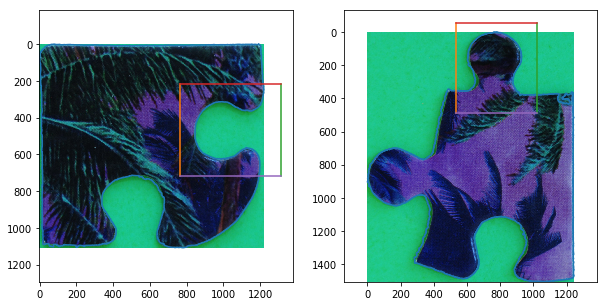

In [6]:
# Assume points are given in clockwise order along the contour.
a1 = np.array([[1160, 574], [1167, 357]])
a2 = np.array([[912, 363], [645, 316]])

def get_mask_bounds(a, margin_narrow=250, margin_wide_short=150, margin_wide_long=400, tab=False):
    delta = np.diff(a, axis=0)[0]
    center = a[0] + delta / 2
    narrow_dir = delta / np.linalg.norm(delta)
    wide_dir = np.cross(narrow_dir, np.array([0, 0, 1]))[:2]
    if tab:
        wide_dir = -wide_dir

    boundary_wide_long = center + wide_dir * margin_wide_long
    boundary_wide_short = center - wide_dir * margin_wide_short
    boundary_narrow1 = center + narrow_dir * margin_narrow
    boundary_narrow2 = center - narrow_dir * margin_narrow

    boundary = np.vstack([boundary_wide_short, boundary_wide_long, boundary_narrow1, boundary_narrow2])
    return np.vstack([np.min(boundary, axis=0), np.max(boundary, axis=0)])


pyplot.figure(figsize=(10, 5))
for i, (p, a, tab) in enumerate(zip((p1, p2), (a1, a2), (False, True))):
    b = get_mask_bounds(a, tab=tab)
    pyplot.subplot(1, 2, i + 1)
    pyplot.plot(p.contour[:, 0], p.contour[:, 1])
    pyplot.imshow(p.image)
    plot_bounds(b)
    pyplot.axis('equal')
pyplot.show()


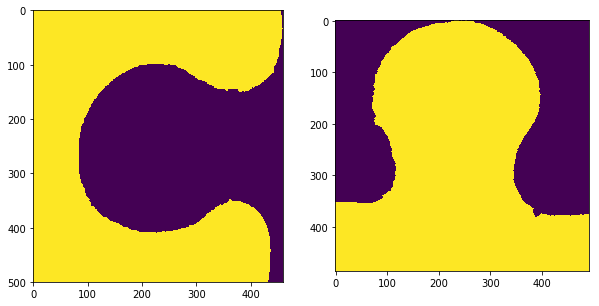

In [7]:
def sub_image(image, bounds):
    xmax, ymax = image.shape
    ylow = np.int(np.clip(bounds[0, 0], 0, ymax))
    yhigh = np.int(np.clip(bounds[1, 0], 0, ymax))
    xlow = np.int(np.clip(bounds[0, 1], 0, xmax))
    xhigh = np.int(np.clip(bounds[1, 1], 0, xmax))
    return image[xlow:xhigh, ylow:yhigh]

pyplot.figure(figsize=(10, 5))
pyplot.subplot(121)
pyplot.imshow(sub_image(p1.mask, get_mask_bounds(a1, tab=False)))
pyplot.subplot(122)
pyplot.imshow(sub_image(p2.mask, get_mask_bounds(a2, tab=True)))
pyplot.show()


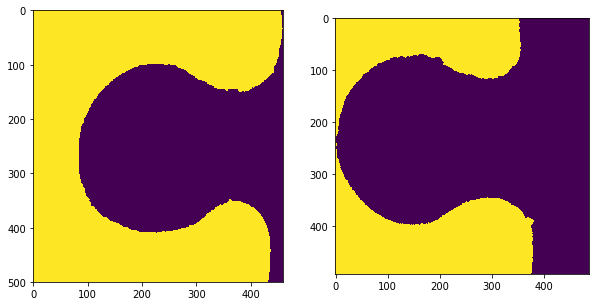

In [8]:
mask1 = sub_image(p1.mask, get_mask_bounds(a1, tab=False))
mask2 = sub_image(p2.mask, get_mask_bounds(a2, tab=True))
mask2 = np.swapaxes(mask2, 1, 0)
mask2 = 1 - mask2
pyplot.figure(figsize=(10, 5))
pyplot.subplot(121)
pyplot.imshow(mask1)
pyplot.subplot(122)
pyplot.imshow(mask2)


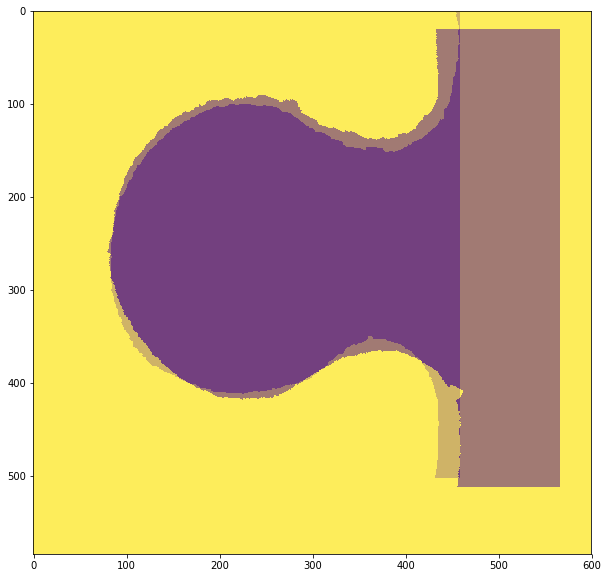

In [22]:
mask1 = sub_image(p1.mask, get_mask_bounds(a1, tab=False))
mask2 = sub_image(p2.mask, get_mask_bounds(a2, tab=True))
mask2 = np.swapaxes(mask2, 1, 0)
# mask2 = 1 - mask2
mask1 = 1 - mask1

canvas_margin = 1.2
canvas_dimensions = (np.max(np.vstack([mask1.shape, mask2.shape]), axis=0) * canvas_margin).astype(np.int)
dim = tuple(canvas_dimensions)

def get_translation_matrix(dx, dy):
    return np.array([[1, 0, dx],
                     [0, 1, dy]]).astype(np.float32)


mask1 = 1 - cv2.warpAffine(mask1.astype(np.float32), get_translation_matrix(0, 2), dim)
mask2 = 1 - cv2.warpAffine(mask2.astype(np.float32), get_translation_matrix(80, 20), dim)

pyplot.figure(figsize=(10, 10))
pyplot.imshow(mask1, alpha=0.5)
pyplot.imshow(mask2, alpha=0.5)
